# Data Preprocessing

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [2]:
# Import data

def import_data(dir, norm=True):
    dfs = []
    min_val,max_val = (None,None)
    for file in os.listdir(dir):
        df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        df = df.drop(columns=[0])
        dfs.append(df)
        min_val = min(df.values.min(), min_val) if min_val else df.values.min()
        max_val = max(df.values.max(), max_val) if max_val else df.values.max()
    for i,df in enumerate(dfs):
        dfs[i] = (df-min_val)/(max_val-min_val)
        
    return dfs, min_val, max_val

train_dfs, train_min, train_max = import_data("/Users/faith/Desktop/Projects/tsad/data/train")
test_dfs, test_min, test_max = import_data("/Users/faith/Desktop/Projects/tsad/data/test")

In [3]:
# Convert to Tensors

downsample = 20
train = torch.FloatTensor(train_dfs[0][::downsample].values)
test = torch.FloatTensor(test_dfs[0][::downsample].values)

In [4]:
# Create Dataset Class

class TimewindowDataset(Dataset):
    def __init__(self, data, window_size):
        self.num_timesteps, self.num_sensors = data.shape
        self.data = torch.flatten(data.T)
        self.window_size = window_size+(self.num_timesteps%window_size)
        
    def __len__(self):
        return (self.num_timesteps*self.num_sensors)-self.window_size
    
    def __getitem__(self,i):
        src = self.data[i:i+self.window_size]
        tgt = self.data[i+1:i+self.window_size+1]
        output = self.data[i+2:i+self.window_size+2]
        return (src, tgt, output)
    
window_size = 4
num_sensors = train.shape[1]

batch_size = 100
train_dataset = TimewindowDataset(train, window_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, drop_last=True, shuffle=False)

# Model

In [5]:
import torch
import torch.nn as nn 
from torch import nn, Tensor
import torch.nn.functional as F
import math
import pandas as pd
from pathlib import Path

In [6]:
class PositionalEncoder(nn.Module):
    def __init__(
        self, 
        dropout: float=0.01, 
        max_seq_len: int=1000, 
        d_model: int=512,
        batch_first: bool=False
        ):

        super().__init__()

        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        if self.batch_first:
            pe = torch.zeros(1, max_seq_len, d_model)
            pe[0, :, 0::2] = torch.sin(position * div_term)
            pe[0, :, 1::2] = torch.cos(position * div_term)
        else:
            pe = torch.zeros(max_seq_len, 1, d_model)
            pe[:, 0, 0::2] = torch.sin(position * div_term)
            pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        if self.batch_first:
            x = x + self.pe[:,:x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)

In [7]:
def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

In [8]:
class TimeSeriesTransformer(nn.Module):

    def __init__(self, 
        input_size: int, # number of input variables. 1 if univariate.
        dec_seq_len: int, # length of the input sequence fed to the decoder
        batch_first: bool,
        dim_val: int=512,  # d_model. All sub-layers in the model produce outputs of dimension dim_val
        n_encoder_layers: int=4, # number of stacked encoder layers in the encoder
        n_decoder_layers: int=4, # number of stacked encoder layers in the decoder
        n_heads: int=1, # number of attention heads (aka parallel attention layers)
        dropout_encoder: float=0.01, 
        dropout_decoder: float=0.01,
        dropout_pos_enc: float=0.01,
        dim_feedforward_encoder: int=300, # number of neurons in the encoder's linear layer
        dim_feedforward_decoder: int=300,# number of neurons in the decoder's linear layer
        num_predicted_features: int=1
        ): 

        super().__init__() 

        self.dec_seq_len = dec_seq_len

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )  
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=num_predicted_features
            )

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
            )

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerDecoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        """
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
        )
        tgt = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        decoder_output = self.decoder(
            tgt=tgt,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask,
        )
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]

        return decoder_output

# Training

In [9]:
epochs = 1

model = TimeSeriesTransformer(
    input_size=1,
    dec_seq_len=window_size,
    batch_first=True,
    num_predicted_features=1,
)

lr=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss(reduction='sum')

# Iterate over all epochs
for epoch in range(epochs):

    # Iterate over all (x,y) pairs in training dataloader
    for i, (src, tgt, tgt_y) in enumerate(train_dataloader):

        # zero the parameter gradients
        optimizer.zero_grad()

        # Generate masks
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(window_size)
        src_mask = nn.Transformer.generate_square_subsequent_mask(window_size)
     
        src = torch.unsqueeze(src, 2)
        tgt = torch.unsqueeze(tgt, 2)
        tgt_y = torch.unsqueeze(tgt_y, 2)
        tgt_mask = torch.unsqueeze(tgt_mask, 0)
        src_mask = torch.unsqueeze(src_mask, 0)
        tgt_mask = tgt_mask.repeat(batch_size,1,1)
        src_mask = src_mask.repeat(batch_size,1,1)

        # Make forecasts
        prediction = model(src, tgt, src_mask, tgt_mask)

        # Compute and backprop loss
        loss = criterion(tgt_y, prediction)

        loss.backward()

        # Take optimizer step
        optimizer.step()

        if i%100 == 0:
            print(f"Epoch {epoch}, item {i}/{len(train_dataloader)}, loss {loss.item()}")        

Epoch 0, item 0/1383, loss 409.1744079589844
Epoch 0, item 100/1383, loss 0.8622431755065918
Epoch 0, item 200/1383, loss 0.4796825349330902
Epoch 0, item 300/1383, loss 0.44760990142822266
Epoch 0, item 400/1383, loss 0.43601545691490173
Epoch 0, item 500/1383, loss 0.3843279778957367
Epoch 0, item 600/1383, loss 0.38576439023017883
Epoch 0, item 700/1383, loss 0.7119948863983154
Epoch 0, item 800/1383, loss 0.3483322262763977
Epoch 0, item 900/1383, loss 0.3089899718761444
Epoch 0, item 1000/1383, loss 0.4781077206134796
Epoch 0, item 1100/1383, loss 0.45569202303886414
Epoch 0, item 1200/1383, loss 0.23716259002685547
Epoch 0, item 1300/1383, loss 60.18505096435547


RuntimeError: stack expects each tensor to be equal size, but got [4] at entry 0 and [3] at entry 35

# Eval

In [10]:
test_dataset = TimewindowDataset(test, window_size)
test_dataloader = DataLoader(test_dataset, shuffle=False)

In [23]:
len(test_dataloader)

138236

In [24]:
# Iterate over all (x,y) pairs in validation dataloader
pred = []
truth = []
with torch.no_grad():
    # Iterate over all (x,y) pairs in training dataloader
    for i, (src, tgt, tgt_y) in enumerate(test_dataloader):
        if i < 10000 and i > 8000:
            print(i)
            # Generate masks
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(window_size)
            src_mask = nn.Transformer.generate_square_subsequent_mask(window_size)

            src = torch.unsqueeze(src, 2)
            tgt = torch.unsqueeze(tgt, 2)
            tgt_y = torch.unsqueeze(tgt_y, 2)
            tgt_mask = torch.unsqueeze(tgt_mask, 0)
            src_mask = torch.unsqueeze(src_mask, 0)

            
            # Make forecasts
            prediction = model(src, tgt, src_mask, tgt_mask)
            pred.append(prediction[0][-1][0])
            truth.append(tgt_y[0][-1][0])
            

8001
8002
8003
8004
8005
8006
8007
8008
8009
8010
8011
8012
8013
8014
8015
8016
8017
8018
8019
8020
8021
8022
8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034
8035
8036
8037
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200


9654
9655
9656
9657
9658
9659
9660
9661
9662
9663
9664
9665
9666
9667
9668
9669
9670
9671
9672
9673
9674
9675
9676
9677
9678
9679
9680
9681
9682
9683
9684
9685
9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698
9699
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
9715
9716
9717
9718
9719
9720
9721
9722
9723
9724
9725
9726
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738
9739
9740
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853


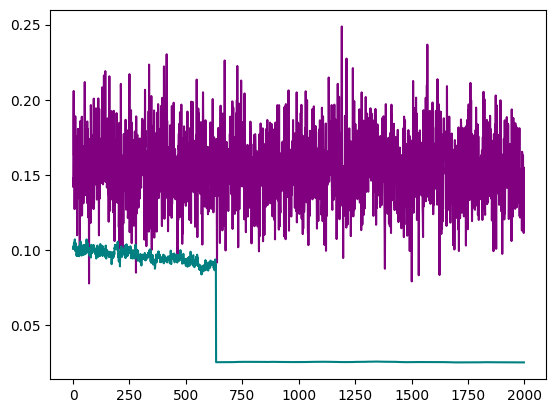

In [25]:
import matplotlib.pyplot as plt
import numpy as np

pred = np.array(pred)
truth = np.array(truth)
plt.plot(pred, color="purple")
plt.plot(truth, color="teal")
plt.show()